# Name: Rawan Mohamed Said
# ID: 4

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as rn

from pathlib import Path
import os
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")

print('Found GPU at: {}'.format(device_name))
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


## Getting the directories of each flower type

In [3]:
file_dir = '/kaggle/input/flowers-recognition'
os.listdir(file_dir)

['flowers']

In [4]:
os.listdir(os.path.join(file_dir, 'flowers'))

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

In [5]:
dandelion_dir = os.path.join(file_dir, 'flowers/dandelion')
daisy_dir = os.path.join(file_dir, 'flowers/daisy')
sunflower_dir = os.path.join(file_dir, 'flowers/sunflower')
tulip_dir = os.path.join(file_dir, 'flowers/tulip')
rose_dir = os.path.join(file_dir, 'flowers/rose')

## Resizing the images and adding them to an array and adding their labels to another array

In [6]:
images = []
labels = []

def make_train_data(flower_type,DIR):
    for img in os.listdir(DIR):
        label= flower_type
        path = os.path.join(DIR,img)
        img = cv.imread(path,cv.IMREAD_COLOR)
        img = cv.resize(img, (224,224)) # change the size of image to 224x224
        images.append(np.array(img))
        labels.append(str(label))

In [7]:
make_train_data('Dandelion',dandelion_dir)
make_train_data('Daisy',daisy_dir)
make_train_data('Sunflower',sunflower_dir)
make_train_data('Tulip',tulip_dir)
make_train_data('Rose',rose_dir)

## Data Visualization

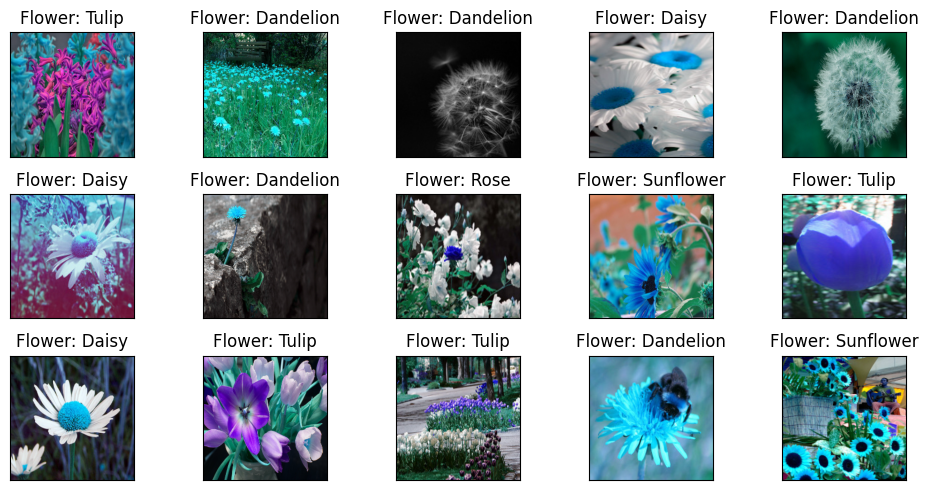

In [8]:
fig,ax=plt.subplots(3,5)
fig.set_size_inches(10,5)
for i in range(3):
    for j in range (5):
        l=rn.randint(0,len(labels))
        ax[i,j].imshow(images[l])
        ax[i,j].set_title('Flower: '+labels[l])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

plt.tight_layout()

## Encoding the labels to one hot vectors

In [9]:
le_labels = np.array(labels)
le=LabelEncoder()
le_labels = le.fit_transform(le_labels)
le_labels = to_categorical(le_labels,5)

## Data Normalization

In [10]:
images = np.array(images)
images = images / 255.0
print("data shape: ",images.shape)

data shape:  (4317, 224, 224, 3)


## Splitting data into training and testing data

In [11]:
# Testing data is 25% of the whole data
x_train,x_test,y_train,y_test=train_test_split(images,le_labels,test_size=0.25,random_state=42)
print("x_train shape",x_train.shape)
print("y_train shape",y_train.shape)
print("x_test shape",x_test.shape)
print("y_test shape",y_test.shape)

x_train shape (3237, 224, 224, 3)
y_train shape (3237, 5)
x_test shape (1080, 224, 224, 3)
y_test shape (1080, 5)


In [12]:
# The test results with the class names (not the one hot vectors)
y_true = le.inverse_transform(np.argmax(y_test,axis = 1))
print('One hot vectors: ', y_test)
print('Class names: ', y_true)

One hot vectors:  [[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
Class names:  ['Rose' 'Sunflower' 'Sunflower' ... 'Dandelion' 'Daisy' 'Rose']


## Data Augmentation

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Augmenting the data and dividing them into batches of size 128
train_gen = datagen.flow(x_train, y_train, batch_size=128)
val_gen = datagen.flow(x_test, y_test, batch_size=128)

## CNN Architecture

In [14]:
import keras
from keras.applications import ResNet50V2
from keras.models import Sequential, Model
from keras.layers import Conv2D, Lambda, MaxPooling2D, Input  # convolution layers
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten              # core layers
from tensorflow.keras.layers import BatchNormalization

In [31]:
cnn_model=Sequential()

cnn_model.add(Input(shape=(224, 224, 3)))

cnn_model.add(Conv2D(filters=64, kernel_size = (5,5) , padding = 'Same', activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(filters=128, kernel_size = (3,3), padding = 'Same', activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

cnn_model.add(Conv2D(filters=256, kernel_size = (3,3), padding = 'Same', activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

cnn_model.add(Conv2D(filters=256, kernel_size = (3,3), padding = 'Same', activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(512,activation="relu"))

cnn_model.add(Dense(5,activation="softmax"))

cnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,657,157 (101.69 MB)

 Trainable params: 26,657,157 (101.69 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model using CNN

In [32]:
# This function is used to stop training when a specified metric (val_accuracy) has stopped improving to prevent overfitting
es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, #
     )

# This function helps the model to converge more effectively and avoid getting stuck in suboptimal regions of the parameter space. 
rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [33]:
results_cnn = cnn_model.fit(train_gen, epochs = 15, validation_data = val_gen, callbacks=[es, rp])

Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2867 - loss: 1.8554 - val_accuracy: 0.4444 - val_loss: 1.2990 - learning_rate: 0.0010
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4713 - loss: 1.2275 - val_accuracy: 0.5148 - val_loss: 1.1538 - learning_rate: 0.0010
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5592 - loss: 1.1195 - val_accuracy: 0.6120 - val_loss: 1.0003 - learning_rate: 0.0010
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6040 - loss: 1.0150 - val_accuracy: 0.6167 - val_loss: 0.9980 - learning_rate: 0.0010
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6278 - loss: 0.9647 - val_accuracy: 0.6537 - val_loss: 0.9122 - learning_rate: 0.0010
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6492 - loss: 0.9183 - val_accuracy: 0.6565 - val_loss: 0.9106 - learning_rate: 0.0010
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6453 - loss: 0.9009 - val_accuracy: 

## Plotting the CNN training results

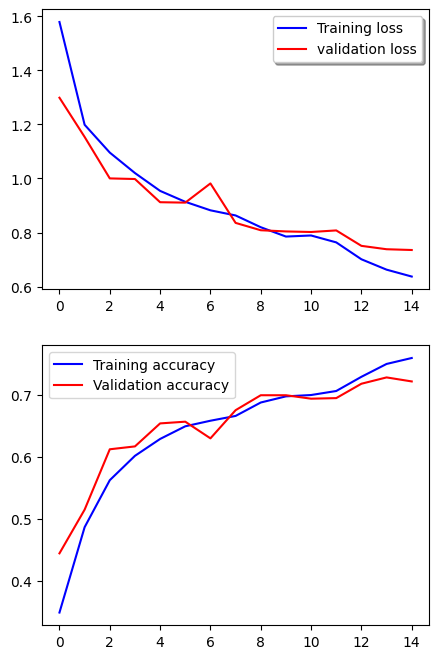

In [34]:
fig, ax = plt.subplots(2,1, figsize=(5, 8))
ax[0].plot(results_cnn.history['loss'], color='b', label="Training loss")
ax[0].plot(results_cnn.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(results_cnn.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(results_cnn.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend()

## Testing the CNN model and visualizing the results

In [35]:
cnn_y_pred = cnn_model.predict(x_test)
cnn_y_pred_classes = le.inverse_transform(np.argmax(cnn_y_pred,axis = 1))

print('CNN Predicted Classes: ', cnn_y_pred_classes)
print('Actual Classes: ', y_true)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
CNN Predicted Classes:  ['Rose' 'Sunflower' 'Sunflower' ... 'Rose' 'Daisy' 'Rose']
Actual Classes:  ['Rose' 'Sunflower' 'Sunflower' ... 'Dandelion' 'Daisy' 'Rose']


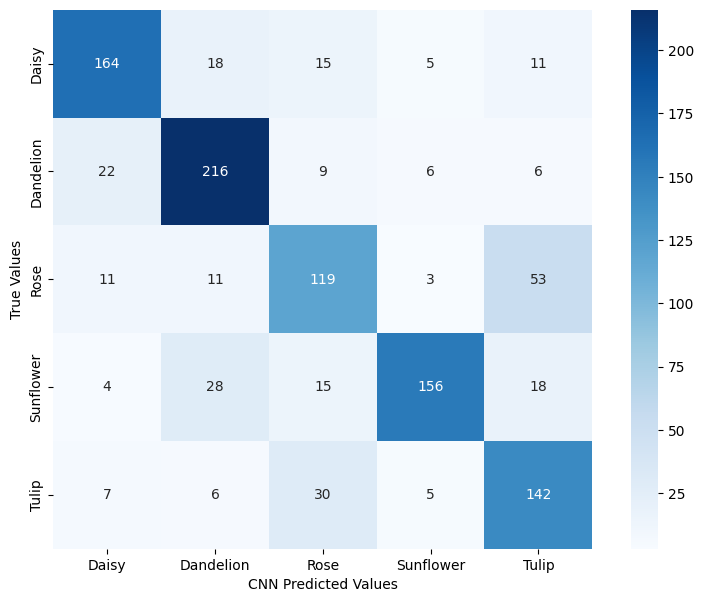

In [36]:
# Plot Confusion matrix
fig = plt.figure(figsize=(10, 7))
mat = confusion_matrix(y_true, cnn_y_pred_classes)

class_labels = le.classes_

sns.heatmap(mat.T, square=True, annot=True, cbar=True, cmap=plt.cm.Blues, fmt='.0f', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('CNN Predicted Values')
plt.ylabel('True Values');
plt.show();

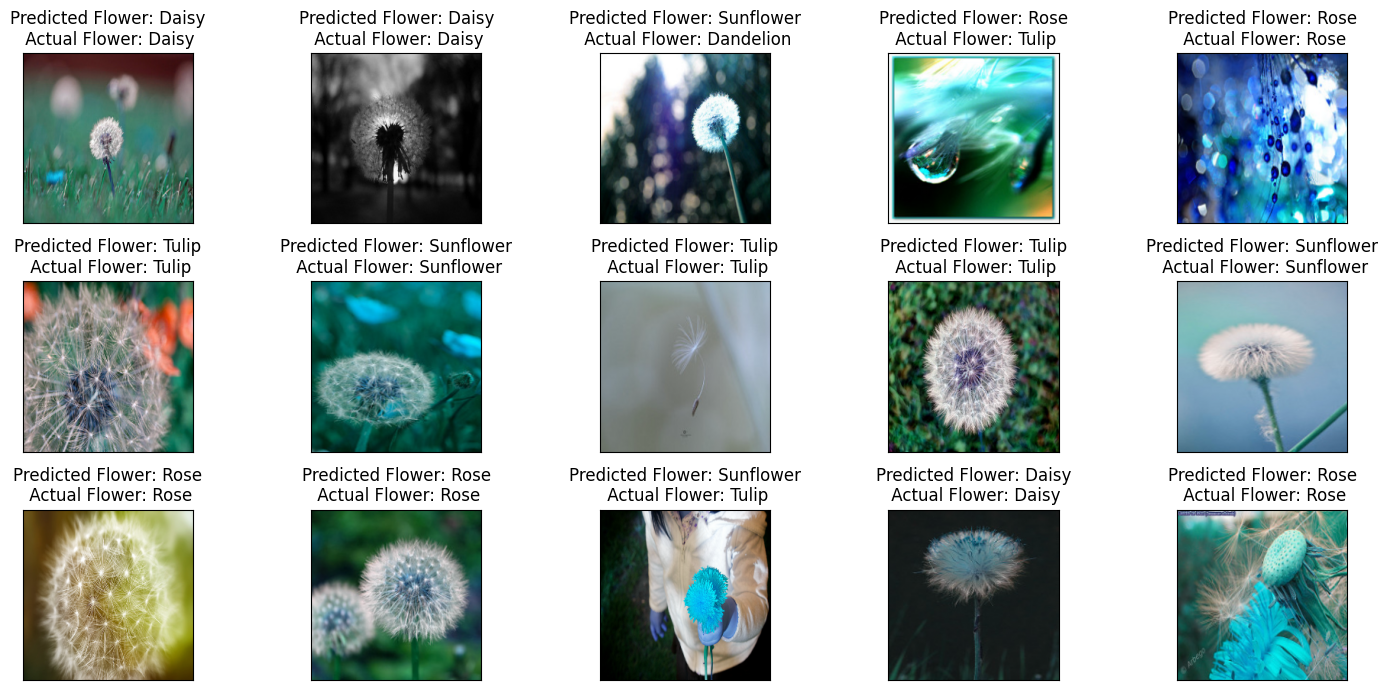

In [37]:
fig,ax=plt.subplots(3,5)
fig.set_size_inches(15,7)
for i in range(3):
    for j in range (5):
        l=rn.randint(0,len(cnn_y_pred))
        ax[i,j].imshow(images[l])
        ax[i,j].set_title('Predicted Flower: '+cnn_y_pred_classes[l] + '\n Actual Flower: '+y_true[l])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

plt.tight_layout()

In [38]:
#Clear gpu's memory

from tensorflow.keras import backend as K
K.clear_session()

import gc
gc.collect()

0

## Training the model using ResNet

In [16]:
resnet_base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(resnet_base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(5, activation='softmax')(x)

resnet_model = Model(inputs=resnet_base_model.input, outputs=x)
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

resnet_model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,616,453 (93.90 MB)

 Trainable params: 24,571,013 (93.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [17]:
results_resnet = resnet_model.fit(train_gen, epochs=15, validation_data=val_gen, callbacks=[es, rp])

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725666117.398071     109 service.cc:145] XLA service 0x7a0e68087db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725666117.398122     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725666117.398126     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725666169.322568     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.6274 - loss: 0.9498 - val_accuracy: 0.5083 - val_loss: 10.1109 - learning_rate: 0.0010
Epoch 2/15


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8251 - loss: 0.4905 - val_accuracy: 0.3093 - val_loss: 18.1565 - learning_rate: 0.0010
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8370 - loss: 0.4321 - val_accuracy: 0.7000 - val_loss: 1.6565 - learning_rate: 0.0010
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8811 - loss: 0.3182 - val_accuracy: 0.4759 - val_loss: 7.4483 - learning_rate: 0.0010
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8553 - loss: 0.3967 - val_accuracy: 0.5546 - val_loss: 6.4058 - learning_rate: 0.0010
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9239 - loss: 0.2429 - val_accuracy: 0.8231 - val_loss: 0.6442 - learning_rate: 0.0010
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9154 - loss: 0.2322 - val_accuracy: 0.7546 - val_loss: 1.5824 - learning_rate: 0.0010
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9237 - loss: 0.2360 - val_accuracy: 0.7000 - v

## Plotting the ResNet training results

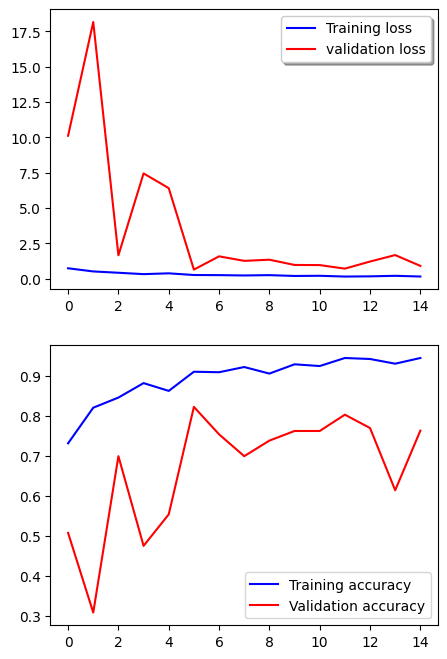

In [18]:
fig, ax = plt.subplots(2,1, figsize=(5, 8))
ax[0].plot(results_resnet.history['loss'], color='b', label="Training loss")
ax[0].plot(results_resnet.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(results_resnet.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(results_resnet.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend()

## Testing the ResNet model and visualizing the results

In [19]:
resnet_y_pred = resnet_model.predict(x_test)
resnet_y_pred_classes = le.inverse_transform(np.argmax(resnet_y_pred,axis = 1))

print('ResNet Predicted Classes: ', resnet_y_pred_classes)
print('Actual Classes: ', y_true)

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 276ms/step
ResNet Predicted Classes:  ['Rose' 'Sunflower' 'Sunflower' ... 'Dandelion' 'Daisy' 'Tulip']
Actual Classes:  ['Rose' 'Sunflower' 'Sunflower' ... 'Dandelion' 'Daisy' 'Rose']


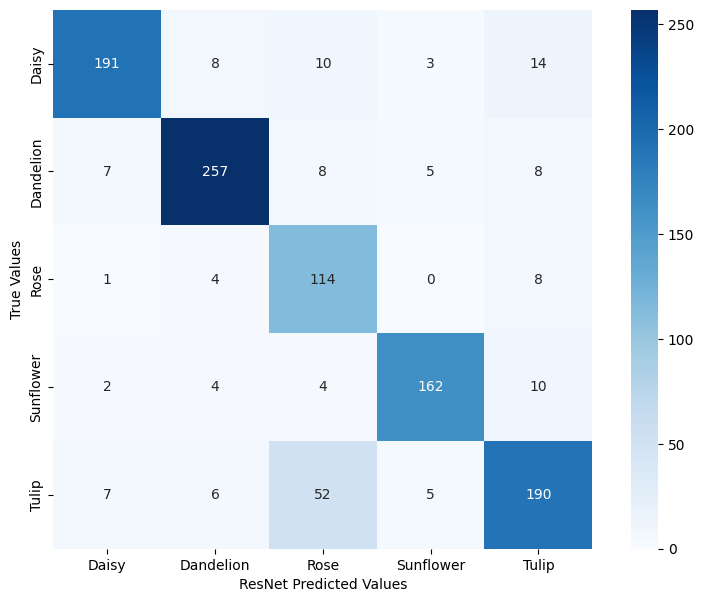

In [20]:
# Plot Confusion matrix
fig = plt.figure(figsize=(10, 7))
mat = confusion_matrix(y_true, resnet_y_pred_classes)

class_labels = le.classes_

sns.heatmap(mat.T, square=True, annot=True, cbar=True, cmap=plt.cm.Blues, fmt='.0f', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('ResNet Predicted Values')
plt.ylabel('True Values');
plt.show();

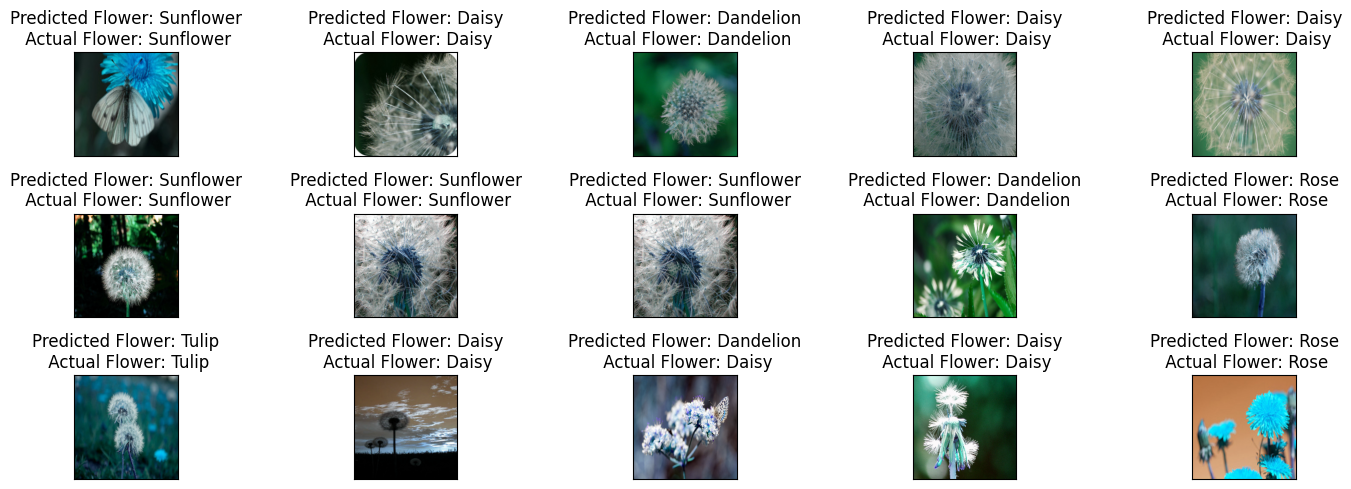

In [21]:
fig,ax=plt.subplots(3,5)
fig.set_size_inches(15,5)
for i in range(3):
    for j in range (5):
        l=rn.randint(0,len(resnet_y_pred))
        ax[i,j].imshow(images[l])
        ax[i,j].set_title('Predicted Flower: '+resnet_y_pred_classes[l] + '\n Actual Flower: '+y_true[l])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

plt.tight_layout()

## Comparing the results of the 2 models

In [39]:
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x_test, y_test, verbose=0)
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(x_test, y_test, verbose=0)

print(f"CNN Model Accuracy: {cnn_test_acc}")
print(f"ResNet Model Accuracy: {resnet_test_acc}")

CNN Model Accuracy: 0.7379629611968994
ResNet Model Accuracy: 0.8462963104248047


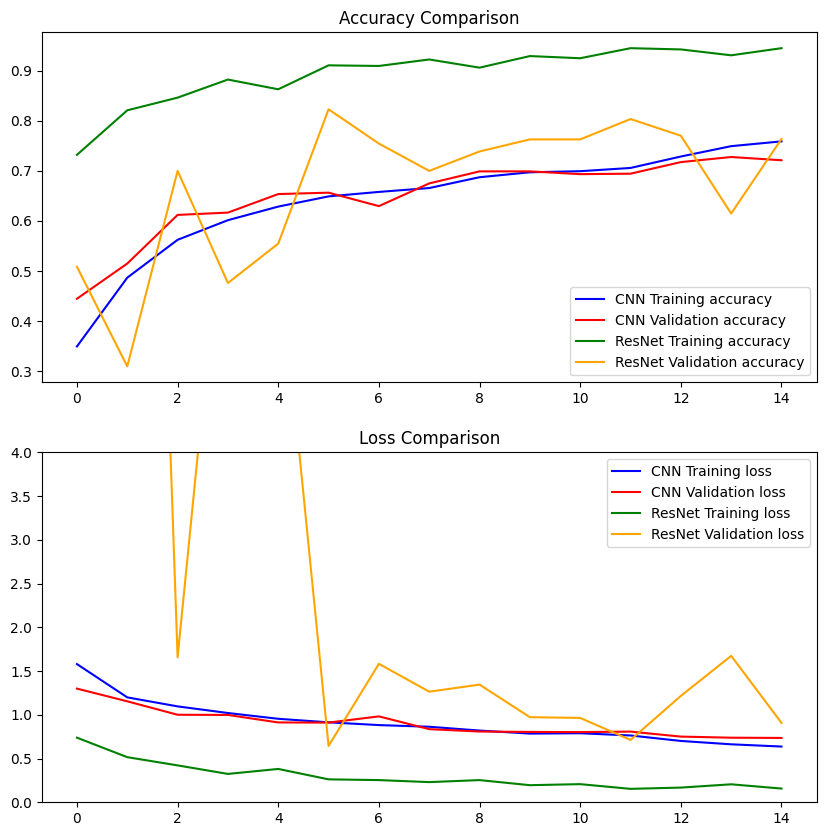

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Accuracy comparison
ax[0].plot(results_cnn.history['accuracy'], label="CNN Training accuracy", color='b')
ax[0].plot(results_cnn.history['val_accuracy'], label="CNN Validation accuracy", color='r')
ax[0].plot(results_resnet.history['accuracy'], label="ResNet Training accuracy", color='g')
ax[0].plot(results_resnet.history['val_accuracy'], label="ResNet Validation accuracy", color='orange')
ax[0].set_title('Accuracy Comparison')
ax[0].legend()

# Loss comparison
ax[1].plot(results_cnn.history['loss'], label="CNN Training loss", color='b')
ax[1].plot(results_cnn.history['val_loss'], label="CNN Validation loss", color='r')
ax[1].plot(results_resnet.history['loss'], label="ResNet Training loss", color='g')
ax[1].plot(results_resnet.history['val_loss'], label="ResNet Validation loss", color='orange')
ax[1].set_title('Loss Comparison')
ax[1].legend()
ax[1].set_ylim([0, 4])

plt.show()